# Financial News Sentiment Analysis
In this notebook, we will perform sentiment analysis on financial news. The outputs will be classified as positive, negative, or neutral.

In [51]:
# Import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os
import re
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# NOTE: Run this section only once to download NLTK datasets
# After running once successfully, you can comment out the section below
"""
# Set the directory for NLTK data
nltk_data_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'nltk_data')
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Configure NLTK data directory
nltk.data.path.insert(0, nltk_data_dir)

# Download required NLTK datasets
print("Downloading NLTK datasets...")
for dataset in ['punkt', 'stopwords', 'wordnet', 'omw-1.4']:
    print(f"Downloading {dataset}...")
    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)
    print(f"{dataset} downloaded.")

# Verify downloaded datasets
print("\nVerifying NLTK datasets...")
try:
    # Test dataset usage
    word_tokenize("Test sentence")
    stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    lemmatizer.lemmatize("testing")
    print("All NLTK datasets successfully loaded and tested.")
except LookupError as e:
    print(f"Error: {str(e)}")
    print("An error occurred while loading NLTK datasets.")
"""

'\n# Set the directory for NLTK data\nnltk_data_dir = os.path.join(os.path.dirname(os.path.abspath(\'__file__\')), \'nltk_data\')\nif not os.path.exists(nltk_data_dir):\n    os.makedirs(nltk_data_dir)\n\n# Configure NLTK data directory\nnltk.data.path.insert(0, nltk_data_dir)\n\n# Download required NLTK datasets\nprint("Downloading NLTK datasets...")\nfor dataset in [\'punkt\', \'stopwords\', \'wordnet\', \'omw-1.4\']:\n    print(f"Downloading {dataset}...")\n    nltk.download(dataset, download_dir=nltk_data_dir, quiet=True)\n    print(f"{dataset} downloaded.")\n\n# Verify downloaded datasets\nprint("\nVerifying NLTK datasets...")\ntry:\n    # Test dataset usage\n    word_tokenize("Test sentence")\n    stopwords.words(\'english\')\n    lemmatizer = WordNetLemmatizer()\n    lemmatizer.lemmatize("testing")\n    print("All NLTK datasets successfully loaded and tested.")\nexcept LookupError as e:\n    print(f"Error: {str(e)}")\n    print("An error occurred while loading NLTK datasets.")\n'

## Loading and Exploring the Dataset

In [52]:
# Load the dataset
df = pd.read_csv('../data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

# Display initial dataset size
print("Initial dataset size:", len(df))

# Data cleaning and encoding: map sentiment labels directly to numeric values
def encode_sentiment(s):
    s = str(s).lower().strip()
    if s in ['negative', 'neg', '-1']:
        return 2  # negative -> 2
    elif s in ['neutral', 'neu', '0']:
        return 0  # neutral -> 0
    elif s in ['positive', 'pos', '1']:
        return 1  # positive -> 1
    else:
        return None  # for unknown values

# Apply encoding
df['sentiment_encoded'] = df['sentiment'].apply(encode_sentiment)

# Remove rows with unknown sentiment (None values)
unknown_count = df['sentiment_encoded'].isna().sum()
if unknown_count > 0:
    print(f"\nRemoving {unknown_count} records with unknown sentiment values")
    df = df.dropna(subset=['sentiment_encoded'])

print("\nDataset size after removing unknown labels:", len(df))

# Store the mapping for reference
sentiment_mapping = {
    'negative': 2,
    'neutral': 0,
    'positive': 1
}
print("\nSentiment Label Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment} -> {code}")

# Convert encoded values to int type
df['sentiment_encoded'] = df['sentiment_encoded'].astype(int)

# Display the distribution of sentiment classes
print("\nDistribution of sentiment classes:")
sentiment_counts = df['sentiment_encoded'].map({2: 'negative', 0: 'neutral', 1: 'positive'}).value_counts()
print(sentiment_counts)

# Display first few rows of the cleaned dataset
print("\nFirst 5 rows of the cleaned dataset:")
print(df[['text', 'sentiment', 'sentiment_encoded']].head())

Initial dataset size: 5843

Removing 1 records with unknown sentiment values

Dataset size after removing unknown labels: 5842

Sentiment Label Mapping:
negative -> 2
neutral -> 0
positive -> 1

Distribution of sentiment classes:
sentiment_encoded
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

First 5 rows of the cleaned dataset:
                                                text sentiment  \
1  The GeoSolutions technology will leverage Bene...  positive   
2  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative   
3  For the last quarter of 2010 , Componenta 's n...  positive   
4  According to the Finnish-Russian Chamber of Co...   neutral   
5  The Swedish buyout firm has sold its remaining...   neutral   

   sentiment_encoded  
1                  1  
2                  2  
3                  1  
4                  0  
5                  0  


## Text Preprocessing
We will clean and process the text data:
1. Convert to lowercase
2. Remove punctuation
3. Remove stop words
4. Apply lemmatization

In [53]:
# Enhanced text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove stock symbols (e.g., $AAPL, $GOOG)
    text = re.sub(r'\$\w+', '', text)
    
    # Remove numbers with % (percentage)
    text = re.sub(r'\d+%', '', text)
    
    # Remove currency symbols and amounts (e.g., $123.45, €100, £50)
    text = re.sub(r'[$€£¥]\d+(?:\.\d{2})?|\d+(?:\.\d{2})?[$€£¥]', '', text)
    
    # Remove special characters and numbers
    # Keep alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    # Add custom financial stop words
    custom_stop_words = {
        'reuters', 'bloomberg', 'cnbc', 'wsj', 'financial', 'times',
        'reported', 'says', 'said', 'according', 'quarter', 'year',
        'month', 'week', 'day', 'today', 'yesterday', 'tomorrow'
    }
    stop_words.update(custom_stop_words)
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization with pos tagging for better accuracy
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]  # First try as verb
    tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]  # Then as noun
    
    # Remove short words (length < 3)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Preprocess texts in the dataset
df['processed_text'] = df['text'].apply(preprocess_text)

# Display examples of processed texts with original for comparison
print("Examples of processed texts:")
comparison_df = pd.DataFrame({
    'Original Text': df['text'],
    'Processed Text': df['processed_text']
})
print(comparison_df.head().to_string())

Examples of processed texts:
                                                                                                                                                                                                                Original Text                                                                                                                                                                       Processed Text
1  The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .  geosolutions technology leverage benefon gps solution provide location base search technology community platform location relevant multimedia content new powerful commercial model
2                                                                                                                                                                    

## Model Comparison
We will compare different models for sentiment analysis:
1. Logistic Regression
2. Random Forest Classifier
3. Support Vector Machine (SVM)
4. Naive Bayes
5. XGBoost

Each model will be evaluated using:
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix

## Data Split and Feature Engineering
First, we'll split our data into training and test sets, then apply TF-IDF vectorization.

In [54]:
# First, let's check class distribution
print("Class distribution before sampling:")
print(df['sentiment'].value_counts())
print("\nMinimum samples per class:", df['sentiment'].value_counts().min())

# Remove classes with too few samples (less than 2)
min_samples = 2
value_counts = df['sentiment'].value_counts()
valid_classes = value_counts[value_counts >= min_samples].index
df_filtered = df[df['sentiment'].isin(valid_classes)].copy()

print("\nClass distribution after filtering rare classes:")
print(df_filtered['sentiment'].value_counts())

Class distribution before sampling:
sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Minimum samples per class: 860

Class distribution after filtering rare classes:
sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64


In [55]:
# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered['processed_text'], 
    df_filtered['sentiment_encoded'],
    test_size=0.2, 
    random_state=42,
    stratify=df_filtered['sentiment_encoded']
)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 4673
Test set size: 1169


In [56]:
# TF-IDF Vectorization with enhanced parameters
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2),  # Include both unigrams and bigrams
    strip_accents='unicode',
    norm='l2'
)

# Transform the text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("\nFeature matrix shape:")
print("Training set:", X_train_tfidf.shape)
print("Test set:", X_test_tfidf.shape)


Feature matrix shape:
Training set: (4673, 5000)
Test set: (1169, 5000)



Training Logistic Regression...
Cross-validation scores: [0.7026738  0.67486631 0.66951872 0.66809422 0.67880086]
Mean CV accuracy: 0.6788 (+/- 0.0251)

Logistic Regression Results:
Test Accuracy: 0.6920

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       626
           1       0.75      0.70      0.72       371
           2       0.39      0.51      0.44       172

    accuracy                           0.69      1169
   macro avg       0.64      0.65      0.64      1169
weighted avg       0.71      0.69      0.70      1169


Logistic Regression Results:
Test Accuracy: 0.6920

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       626
           1       0.75      0.70      0.72       371
           2       0.39      0.51      0.44       172

    accuracy                           0.69      1169
   macro avg       0.64      0.65      0.6

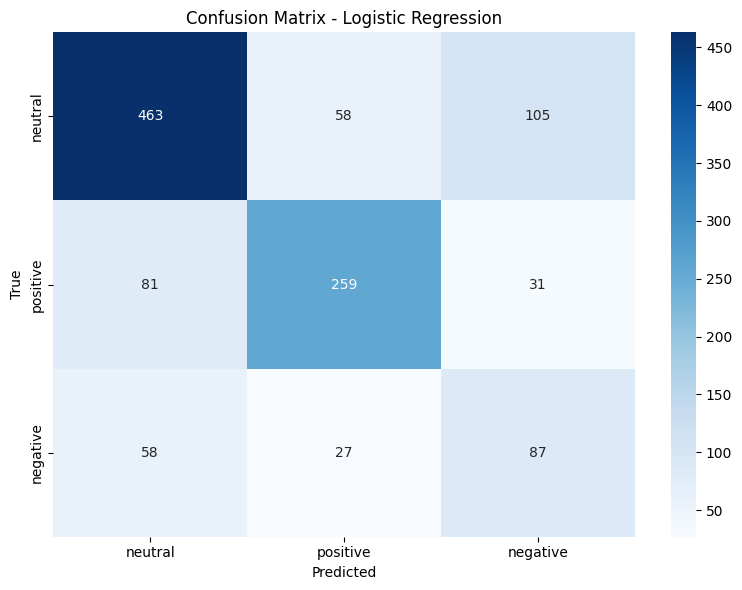


Training Random Forest...
Cross-validation scores: [0.67700535 0.6684492  0.65775401 0.66488223 0.68094218]
Mean CV accuracy: 0.6698 (+/- 0.0167)
Cross-validation scores: [0.67700535 0.6684492  0.65775401 0.66488223 0.68094218]
Mean CV accuracy: 0.6698 (+/- 0.0167)

Random Forest Results:
Test Accuracy: 0.6630

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       626
           1       0.76      0.51      0.61       371
           2       0.41      0.53      0.46       172

    accuracy                           0.66      1169
   macro avg       0.63      0.61      0.61      1169
weighted avg       0.68      0.66      0.66      1169


Random Forest Results:
Test Accuracy: 0.6630

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       626
           1       0.76      0.51      0.61       371
           2       0.41      0.53      0.46      

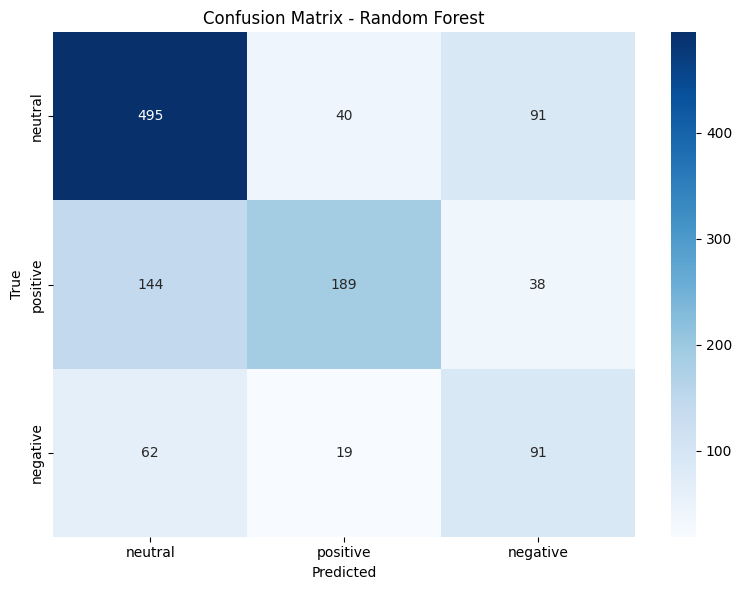


Training SVM...
Cross-validation scores: [0.70695187 0.67379679 0.65347594 0.66809422 0.66381156]
Mean CV accuracy: 0.6732 (+/- 0.0363)
Cross-validation scores: [0.70695187 0.67379679 0.65347594 0.66809422 0.66381156]
Mean CV accuracy: 0.6732 (+/- 0.0363)

SVM Results:
Test Accuracy: 0.6766

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       626
           1       0.78      0.64      0.70       371
           2       0.36      0.40      0.38       172

    accuracy                           0.68      1169
   macro avg       0.62      0.60      0.61      1169
weighted avg       0.68      0.68      0.68      1169


SVM Results:
Test Accuracy: 0.6766

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       626
           1       0.78      0.64      0.70       371
           2       0.36      0.40      0.38       172

    accuracy            

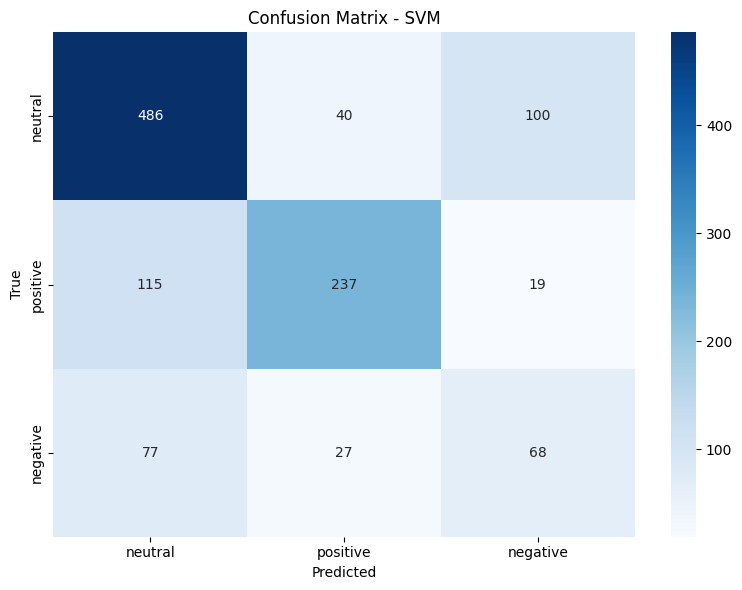


Training Naive Bayes...
Cross-validation scores: [0.71550802 0.66737968 0.64171123 0.68736617 0.67130621]
Mean CV accuracy: 0.6767 (+/- 0.0487)

Naive Bayes Results:
Test Accuracy: 0.6732

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.88      0.77       626
           1       0.70      0.56      0.62       371
           2       0.46      0.18      0.26       172

    accuracy                           0.67      1169
   macro avg       0.61      0.54      0.55      1169
weighted avg       0.65      0.67      0.65      1169



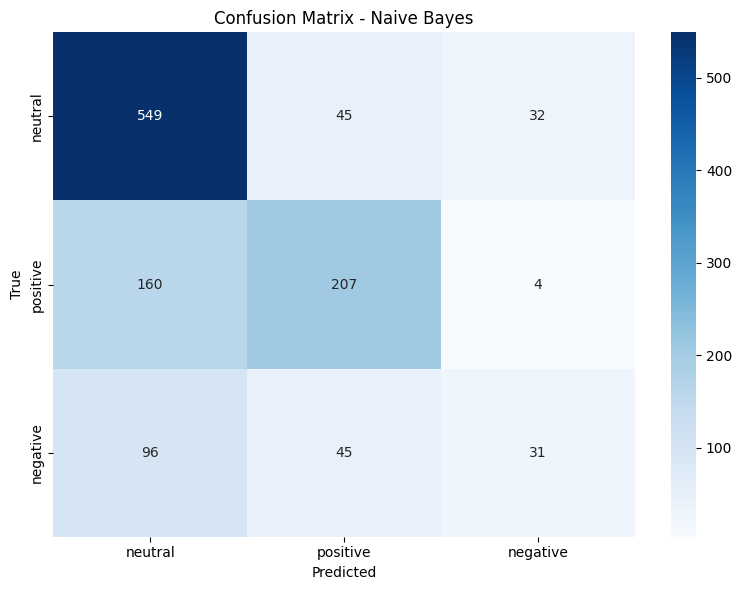


Training XGBoost...
Cross-validation scores: [0.66631016 0.6459893  0.65668449 0.65203426 0.65738758]
Mean CV accuracy: 0.6557 (+/- 0.0134)
Cross-validation scores: [0.66631016 0.6459893  0.65668449 0.65203426 0.65738758]
Mean CV accuracy: 0.6557 (+/- 0.0134)
[0]	validation_0-mlogloss:1.01173	validation_1-mlogloss:1.01483
[0]	validation_0-mlogloss:1.01173	validation_1-mlogloss:1.01483
[1]	validation_0-mlogloss:0.99139	validation_1-mlogloss:0.99738
[1]	validation_0-mlogloss:0.99139	validation_1-mlogloss:0.99738
[2]	validation_0-mlogloss:0.97404	validation_1-mlogloss:0.98254
[2]	validation_0-mlogloss:0.97404	validation_1-mlogloss:0.98254
[3]	validation_0-mlogloss:0.95755	validation_1-mlogloss:0.96887
[3]	validation_0-mlogloss:0.95755	validation_1-mlogloss:0.96887
[4]	validation_0-mlogloss:0.94254	validation_1-mlogloss:0.95652
[4]	validation_0-mlogloss:0.94254	validation_1-mlogloss:0.95652
[5]	validation_0-mlogloss:0.92920	validation_1-mlogloss:0.94594
[5]	validation_0-mlogloss:0.92920	v

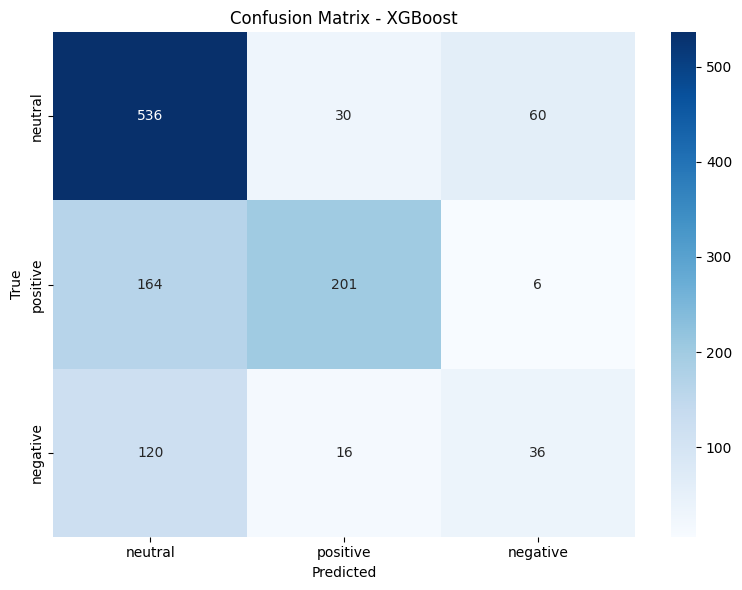


Training LightGBM...
Cross-validation scores: [0.60855615 0.60962567 0.59572193 0.61027837 0.624197  ]
Mean CV accuracy: 0.6097 (+/- 0.0180)
Cross-validation scores: [0.60855615 0.60962567 0.59572193 0.61027837 0.624197  ]
Mean CV accuracy: 0.6097 (+/- 0.0180)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10505
[LightGBM] [Info] Number of data points in the train set: 4673, number of used features: 544
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

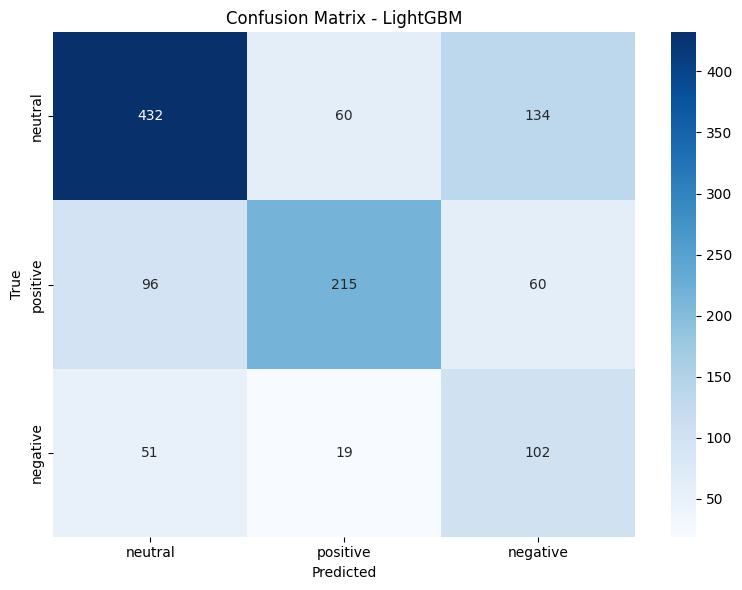

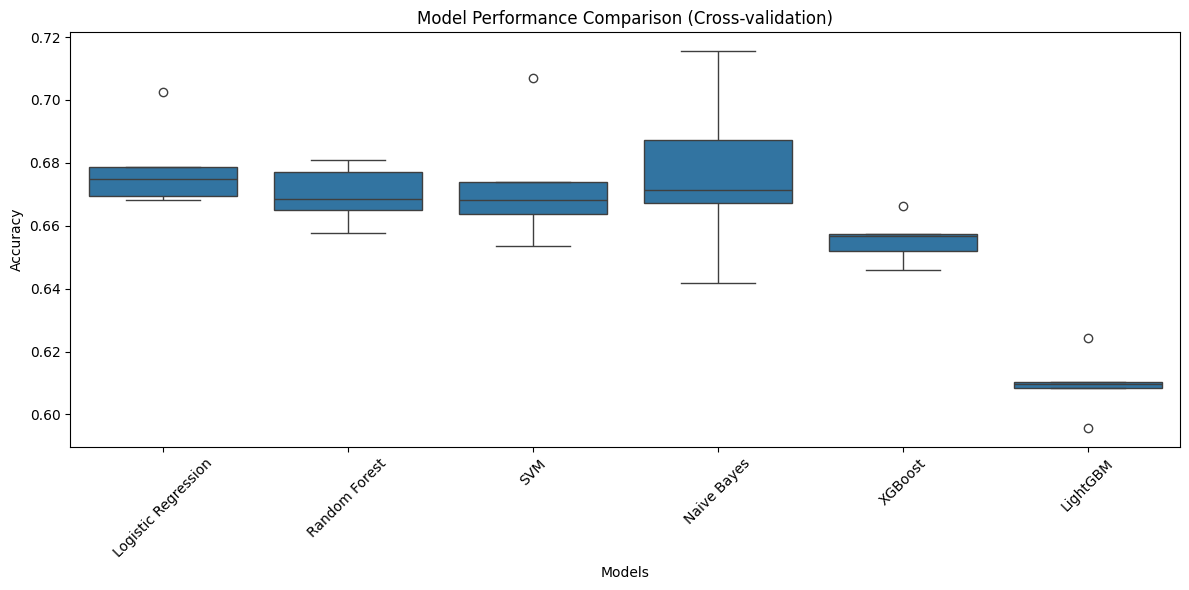

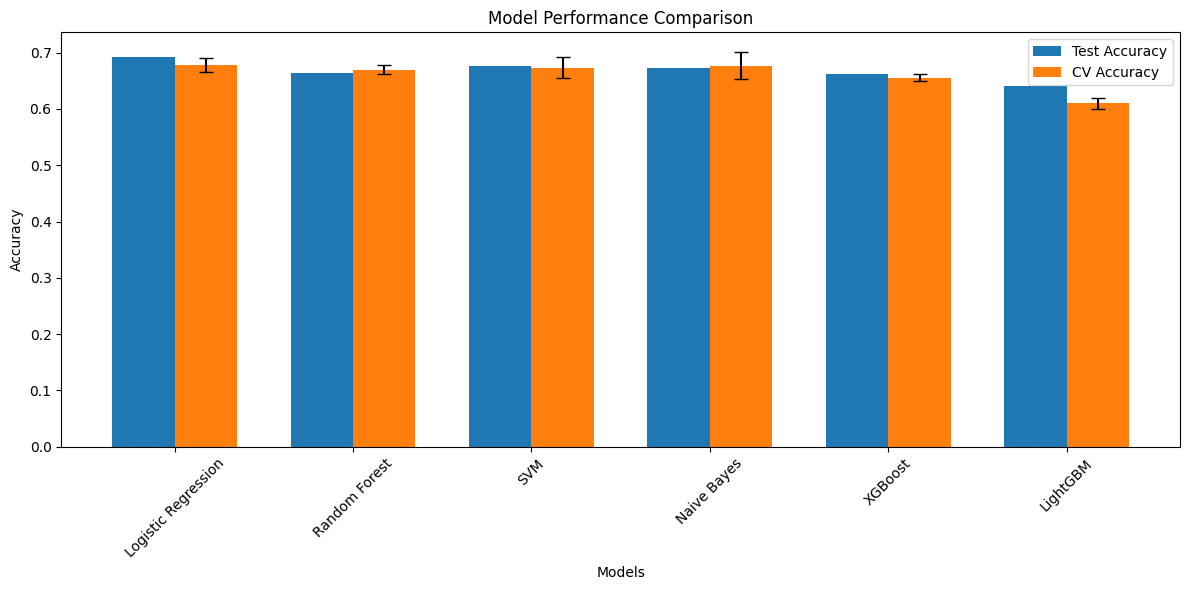


Best performing model: Logistic Regression
Test Accuracy: 0.6920
Mean CV Accuracy: 0.6788


In [57]:
# Initialize models with optimized configurations
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        multi_class='multinomial',
        class_weight='balanced',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=30,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        random_state=42,
        probability=True
    ),
    'Naive Bayes': MultinomialNB(
        alpha=0.5
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='multi:softmax',
        num_class=3  # Three classes (0: neutral, 1: positive, 2: negative)
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=200,
        num_leaves=31,
        max_depth=7,
        learning_rate=0.1,
        class_weight='balanced',
        random_state=42,
        objective='multiclass',
        n_jobs=-1
    )
}

# Dictionary to store results
results = {}

# Create StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")
        
        # All models can now work with the same labels (0,1,2)
        # Perform cross-validation
        cv_scores = cross_val_score(
            model, 
            X_train_tfidf if name not in ['XGBoost', 'LightGBM'] else X_train_tfidf.toarray(), 
            y_train, 
            cv=skf, 
            scoring='accuracy',
            n_jobs=-1
        )
        
        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train the model on full training data
        if name == 'XGBoost':
            # For XGBoost, use eval_set
            eval_set = [(X_train_tfidf.toarray(), y_train), (X_test_tfidf.toarray(), y_test)]
            model.fit(X_train_tfidf.toarray(), y_train,
                     eval_set=eval_set)
            y_pred = model.predict(X_test_tfidf.toarray())
        elif name == 'LightGBM':
            # For LightGBM, use eval_set
            eval_set = [(X_test_tfidf.toarray(), y_test)]
            model.fit(X_train_tfidf.toarray(), y_train,
                     eval_set=eval_set)
            y_pred = model.predict(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
        
        # Store results
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'cv_scores': cv_scores
        }
        
        # Print results
        print(f"\n{name} Results:")
        print(f"Test Accuracy: {results[name]['accuracy']:.4f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sentiment_names = ['neutral', 'positive', 'negative']  # Ordered by their numeric values (0,1,2)
        sns.heatmap(results[name]['confusion_matrix'], 
                   annot=True, 
                   fmt='d', 
                   cmap='Blues',
                   xticklabels=sentiment_names,
                   yticklabels=sentiment_names)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
    
    except Exception as e:
        print(f"\nError training {name}:")
        print(str(e))
        continue

# Create a more detailed comparison plot
plt.figure(figsize=(12, 6))

# Box plot for cross-validation scores
cv_data = []
model_names = []
for name in results.keys():
    cv_data.extend(results[name]['cv_scores'])
    model_names.extend([name] * len(results[name]['cv_scores']))

sns.boxplot(x=model_names, y=cv_data)
plt.title('Model Performance Comparison (Cross-validation)')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot for test accuracy with error bars from CV
plt.figure(figsize=(12, 6))
test_accuracies = [results[name]['accuracy'] for name in results.keys()]
cv_means = [results[name]['cv_scores'].mean() for name in results.keys()]
cv_stds = [results[name]['cv_scores'].std() for name in results.keys()]

x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, test_accuracies, width, label='Test Accuracy')
plt.bar(x + width/2, cv_means, width, label='CV Accuracy')
plt.errorbar(x + width/2, cv_means, yerr=cv_stds, fmt='none', color='black', capsize=5)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, list(results.keys()), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Find the best performing model
if results:
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    print(f"\nBest performing model: {best_model_name}")
    print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
    print(f"Mean CV Accuracy: {results[best_model_name]['cv_scores'].mean():.4f}")
else:
    print("\nNo models were successfully trained")

## Hyperparameter Optimization
We will perform hyperparameter optimization on the best performing model using GridSearchCV.

Performing GridSearchCV for Logistic Regression...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters found:
{'C': 1, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

Best cross-validation accuracy: 0.6852

Optimized Model Performance on Test Set:
Accuracy: 0.6955

Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.17      0.25       172
     neutral       0.69      0.89      0.78       626
    positive       0.77      0.60      0.68       371

    accuracy                           0.70      1169
   macro avg       0.64      0.56      0.57      1169
weighted avg       0.68      0.70      0.67      1169


Best parameters found:
{'C': 1, 'class_weight': None, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

Best cross-validation accuracy: 0.6852

Optimized Model Performance on Test Set:
Accuracy: 0.6955

Classification Report:
              preci

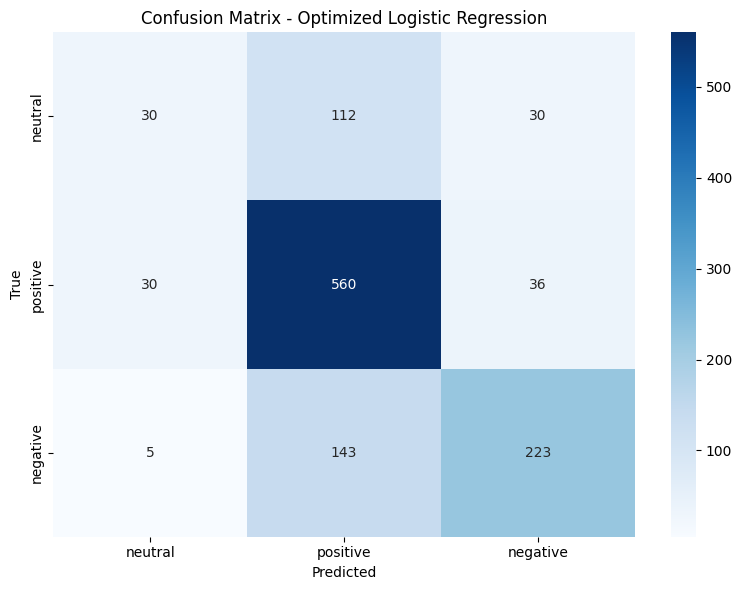

In [59]:
# Define parameter grid for each model type
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'multi_class': ['multinomial'],
        'class_weight': ['balanced', None]
    },
    'Random Forest': {
        'n_estimators': [200, 300, 400],
        'max_depth': [20, 30, 40, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': ['balanced', None]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0],
        'fit_prior': [True, False]
    },
    'XGBoost': {
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [200, 300, 400],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    },
    'LightGBM': {
        'num_leaves': [31, 63, 127],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [200, 300, 400],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_samples': [20, 40, 60]
    }
}

# Get the best model and its parameter grid
best_model = models[best_model_name]
best_model_params = param_grids[best_model_name]

# Create GridSearchCV with adjusted parameters
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=best_model_params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Use stratified k-fold
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    error_score='raise'
)

# Prepare data based on model type
if best_model_name in ['XGBoost', 'LightGBM']:
    X_train_model = X_train_tfidf.toarray()
    X_test_model = X_test_tfidf.toarray()
else:
    X_train_model = X_train_tfidf
    X_test_model = X_test_tfidf

# Fit GridSearchCV
print(f"Performing GridSearchCV for {best_model_name}...")
grid_search.fit(X_train_model, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_model)

# Map numeric predictions to sentiment labels
sentiment_labels = {0: 'neutral', 1: 'positive', 2: 'negative'}  # Updated mapping
y_test_labels = [sentiment_labels[y] for y in y_test]
y_pred_labels = [sentiment_labels[y] for y in y_pred]

print("\nOptimized Model Performance on Test Set:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Plot confusion matrix with sentiment labels
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_labels, y_pred_labels)
sentiment_names = ['neutral', 'positive', 'negative']  # Updated order to match numeric values (0,1,2)
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=sentiment_names,
            yticklabels=sentiment_names)
plt.title(f'Confusion Matrix - Optimized {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Feature importance analysis for tree-based models
if best_model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    # Get feature importance
    if best_model_name == 'Random Forest':
        importance = best_model.feature_importances_
    elif best_model_name in ['XGBoost', 'LightGBM']:
        importance = best_model.feature_importances_
    
    # Get feature names
    feature_names = tfidf.get_feature_names_out()
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Plot top 20 most important features
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title(f'Top 20 Most Important Features - {best_model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

## Model Testing
Let's test the model on new texts.

In [60]:
# Function for predicting sentiment of new texts
def predict_sentiment(text):
    # Preprocess text
    processed = preprocess_text(text)
    # TF-IDF transformation
    text_tfidf = tfidf.transform([processed])
    
    # Convert to array if using XGBoost or LightGBM
    if best_model_name in ['XGBoost', 'LightGBM']:
        text_tfidf = text_tfidf.toarray()
    
    # Get numeric prediction
    prediction_encoded = best_model.predict(text_tfidf)[0]
    
    # Convert numeric prediction to sentiment label
    sentiment_labels = {0: 'neutral', 1: 'positive', 2: 'negative'}
    prediction = sentiment_labels[prediction_encoded]
    
    return prediction

In [61]:
# Test examples
test_texts = [
    "Stock market reaches all-time high as tech sector booms",
    "Company announces massive layoffs amid financial troubles",
    "Market remains stable as Fed maintains current interest rates"
]

# Make predictions on test examples
print("Test Results:")
for text in test_texts:
    sentiment = predict_sentiment(text)
    print(f"\nText: {text}")
    print(f"Predicted sentiment: {sentiment}")

Test Results:

Text: Stock market reaches all-time high as tech sector booms
Predicted sentiment: positive

Text: Company announces massive layoffs amid financial troubles
Predicted sentiment: neutral

Text: Market remains stable as Fed maintains current interest rates
Predicted sentiment: neutral
